                 Demand
year_month             
2017-01-01  1211.009490
2017-02-01  1660.584649
2017-03-01  3182.587014
2017-04-01  3506.515270
2017-05-01  4554.082280


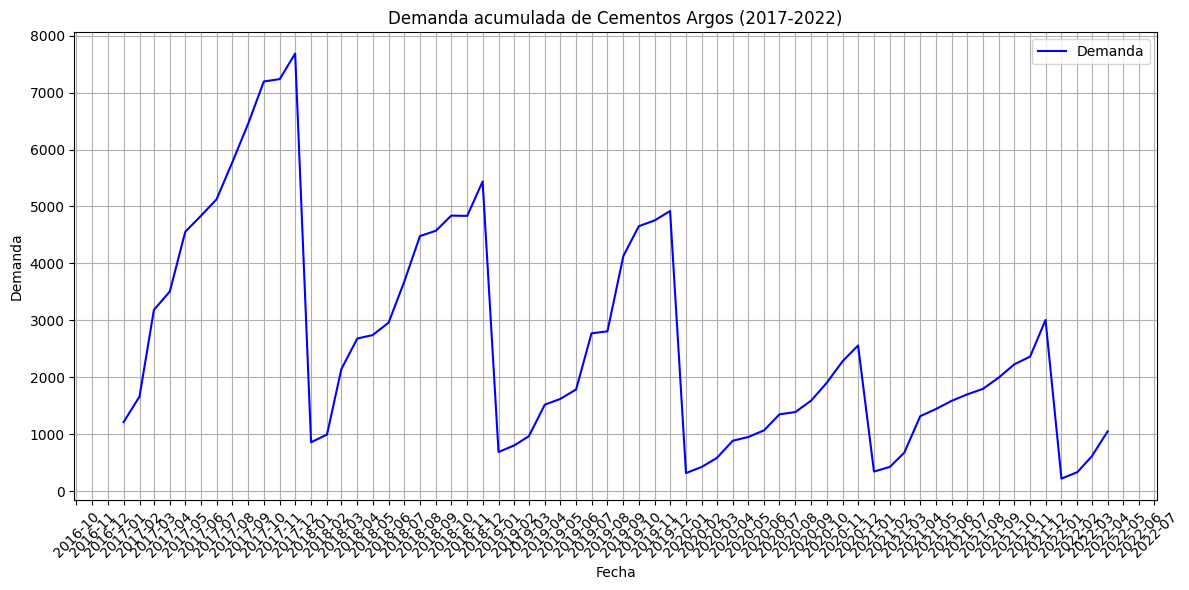

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error
from statsmodels.tsa.holtwinters import ExponentialSmoothing
from matplotlib.dates import DateFormatter
import matplotlib.dates as mdates
import itertools
import os


data = pd.read_csv('bds/dataset_demand_acumulate.csv', parse_dates=['year_month'])
data['year_month'] = pd.to_datetime(data['year_month'])
data.set_index('year_month', inplace=True)  # Establecer 'year_month' como índice

print(data.head())

# Graficar la demanda a lo largo del tiempo
plt.figure(figsize=(12, 6))
plt.plot(data.index, data['Demand'], label='Demanda', color='b')
plt.title('Demanda acumulada de Cementos Argos (2017-2022)')
plt.xlabel('Fecha')
plt.ylabel('Demanda')

# Configurar el formato del eje X
plt.gca().xaxis.set_major_locator(mdates.MonthLocator())
plt.gca().xaxis.set_major_formatter(mdates.DateFormatter('%Y-%m'))

plt.legend()
plt.grid(True)
plt.xticks(rotation=45)
plt.tight_layout()  # Ajustar el diseño para que no se corte el contenido
plt.show()

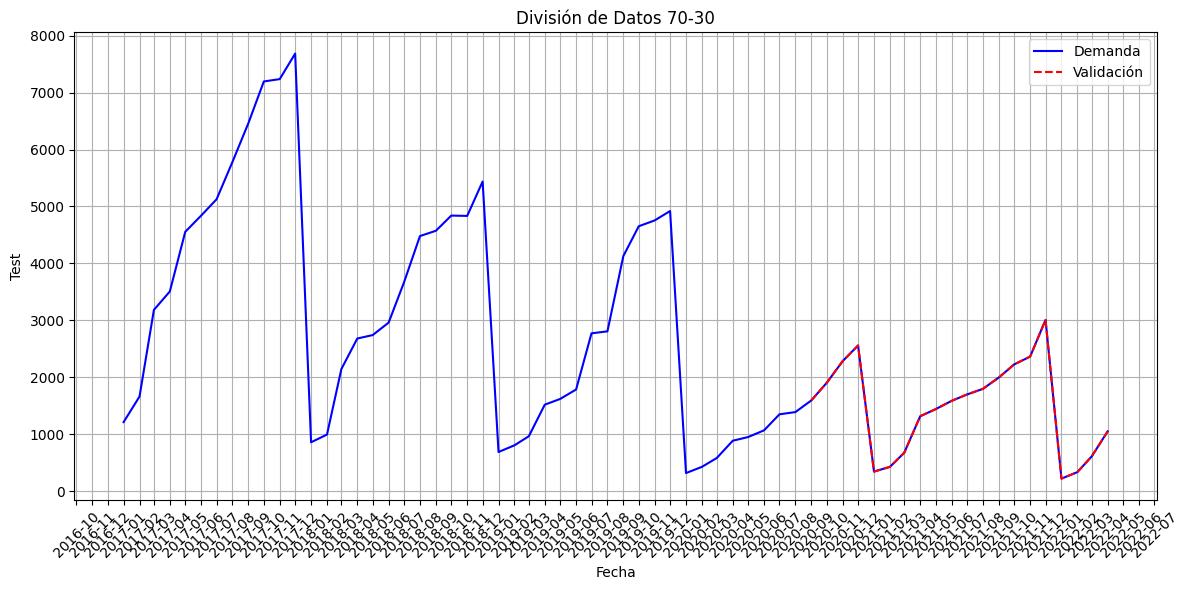

In [2]:

train_size = int(len(data) * 0.7)
train_data, validation_data = data.iloc[:train_size], data.iloc[train_size:]

# Concatenar los datos de entrenamiento y validación para graficar
combined_data = pd.concat([train_data, validation_data], axis=0)

# Graficar los datos
plt.figure(figsize=(12, 6))

# Graficar todos los datos en una sola línea continua
plt.plot(combined_data.index, combined_data['Demand'], label='Demanda', color='b')

# Graficar entrenamiento y validación con diferentes estilos

plt.plot(validation_data.index, validation_data['Demand'], label='Validación', color='r', linestyle='--')

# Configurar el formato del eje X
plt.gca().xaxis.set_major_locator(mdates.MonthLocator())
plt.gca().xaxis.set_major_formatter(mdates.DateFormatter('%Y-%m'))

# Etiquetas y título
plt.title('División de Datos 70-30')
plt.xlabel('Fecha')
plt.ylabel('Test')
plt.legend()

# Ajustes adicionales
plt.grid(True)
plt.xticks(rotation=45)
plt.tight_layout()  # Ajustar el diseño para que no se corte el contenido

# Mostrar gráfico
plt.show()

In [3]:
# Entrenar modelo
model = ExponentialSmoothing(train_data['Demand'], seasonal='add', seasonal_periods=12).fit()

/Users/cristiantabaresbran/opt/anaconda3/lib/python3.10/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)


RMSE: 1389.1208195945774


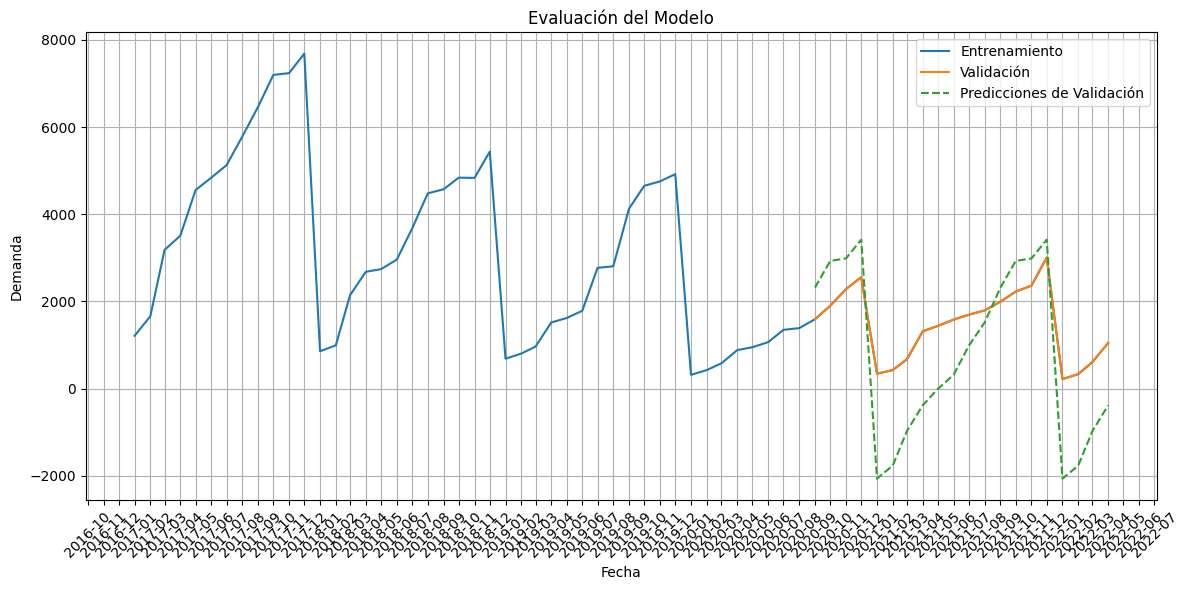

In [4]:
# Realizar predicciones en el conjunto de validación
validation_predictions = model.predict(start=validation_data.index[0], end=validation_data.index[-1])

# Calcular métricas de evaluación
mse = mean_squared_error(validation_data['Demand'], validation_predictions)
rmse = mse ** 0.5
print(f'RMSE: {rmse}')

# Graficar predicciones en el conjunto de validación
plt.figure(figsize=(12, 6))
plt.plot(combined_data.index, combined_data['Demand'], label='Entrenamiento')
plt.plot(validation_data.index, validation_data['Demand'], label='Validación')
plt.plot(validation_data.index, validation_predictions, label='Predicciones de Validación', linestyle='--')
plt.title('Evaluación del Modelo')
plt.xlabel('Fecha')
plt.ylabel('Demanda')
plt.legend()
# Configurar el formato del eje X
plt.gca().xaxis.set_major_locator(mdates.MonthLocator())
plt.gca().xaxis.set_major_formatter(mdates.DateFormatter('%Y-%m'))

plt.legend()
plt.grid(True)
plt.xticks(rotation=45)
plt.tight_layout()  # Ajustar el diseño para que no se corte el contenido
plt.show()


In [5]:
# Realizar pronósticos para mayo, junio y julio de 2022
model = ExponentialSmoothing(data['Demand'], seasonal='add', seasonal_periods=12).fit()
forecast = model.predict(start='2022-05-01', end='2022-07-01')
print(forecast)

2022-05-01    1405.754001
2022-06-01    1639.193342
2022-07-01    2187.117148
Freq: MS, dtype: float64


/Users/cristiantabaresbran/opt/anaconda3/lib/python3.10/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)


In [6]:
forecast_df = forecast.reset_index()
forecast_df.columns = ['year_month', 'Demand']

# Convertir la columna 'Fecha' a tipo datetime
forecast_df['year_month'] = pd.to_datetime(forecast_df['year_month'])
combined_data = combined_data.reset_index()
df_last = pd.concat([combined_data, forecast_df], axis=0).reset_index(drop=True)

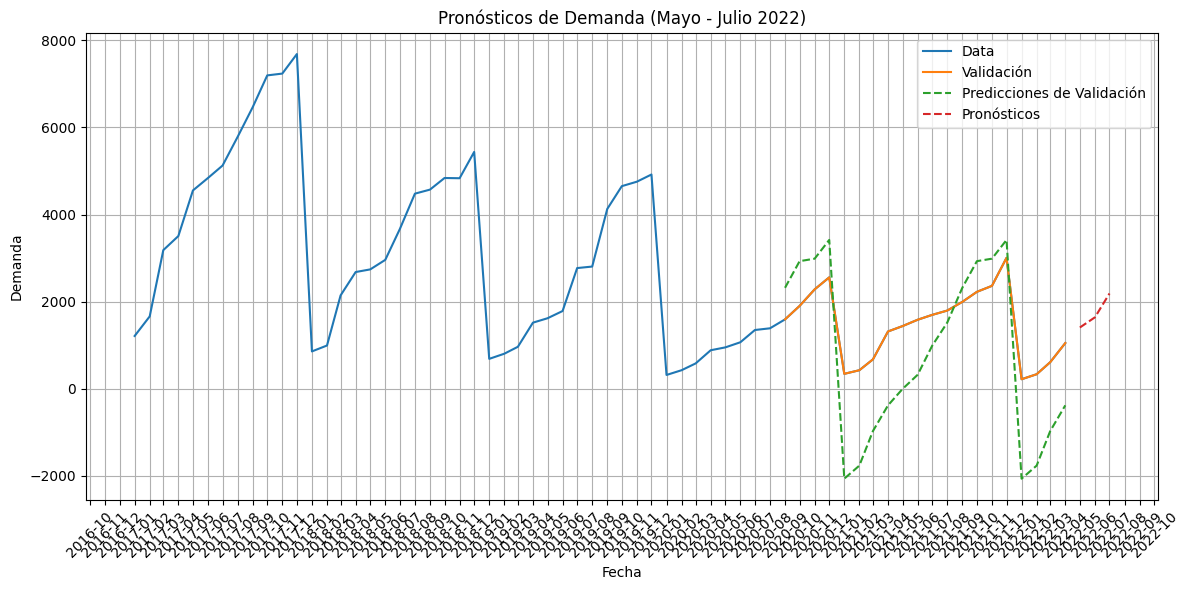

In [7]:
plt.figure(figsize=(12, 6))
plt.plot(combined_data.year_month, combined_data['Demand'], label='Data')
plt.plot(validation_data.index, validation_data['Demand'], label='Validación')
plt.plot(validation_data.index, validation_predictions, label='Predicciones de Validación', linestyle='--')
plt.plot(forecast.index, forecast, label='Pronósticos', linestyle='--')
plt.title('Pronósticos de Demanda (Mayo - Julio 2022)')
plt.xlabel('Fecha')
plt.ylabel('Demanda')
plt.legend()
plt.gca().xaxis.set_major_locator(mdates.MonthLocator())
plt.gca().xaxis.set_major_formatter(mdates.DateFormatter('%Y-%m'))

plt.legend()
plt.grid(True)
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()

In [8]:
# Optimizar modelo

def tes_optimizer(train_data, validation_data, abg, trend_mode='add', seasonal_mode='add', seasonal_period=12, step=20):

    best_alpha, best_beta, best_gamma, best_rmse = None, None, None, float("inf")
    
    for comb in abg:
        tes_model = ExponentialSmoothing(train_data, trend=trend_mode, seasonal=seasonal_mode, seasonal_periods=seasonal_period).fit(
            smoothing_level=comb[0], smoothing_trend=comb[1], smoothing_seasonal=comb[2]
        )
        y_pred = tes_model.forecast(step)
        mse = mean_squared_error(validation_data, y_pred)
        rmse = mse ** 0.5
        
        if rmse < best_rmse:
            best_alpha, best_beta, best_gamma, best_rmse = comb[0], comb[1], comb[2], rmse
            
        print([round(comb[0], 2), round(comb[1], 2), round(comb[2], 2), round(rmse, 2)])
        print("best_alpha:", round(best_alpha, 2), "best_beta:", round(best_beta, 2), "best_gamma:", round(best_gamma, 2),
              "best_mae:", round(best_rmse, 4))
        
    return best_alpha, best_beta, best_gamma, best_rmse


In [9]:
def plot_co2(train, test, y_pred, title):

    mse = mean_squared_error(test, y_pred)
    rmse = mse ** 0.5
    print(f'RMSE: {rmse}')
    train["2015":].plot(legend=True, label="TRAIN", title=f"{title}, RMSE: {round(rmse,2)}")
    test.plot(legend=True, label="TEST", figsize=(12, 6))
    y_pred.plot(legend=True, label="PREDICTION")
    plt.grid(True)
    plt.show()

In [10]:
alphas = betas = gammas = np.arange(0.10, 1, 0.20)
abg = list(itertools.product(alphas, betas, gammas))

In [11]:
model = ExponentialSmoothing(train_data['Demand'],
   trend="add",
   seasonal="add",
   seasonal_periods=12
   ).fit(smoothing_level=0.5,
         smoothing_trend=0.5,
         smoothing_seasonal=0.5
   )

/Users/cristiantabaresbran/opt/anaconda3/lib/python3.10/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)


In [12]:
y_pred = model.forecast(20)

RMSE: 5523.894688390758


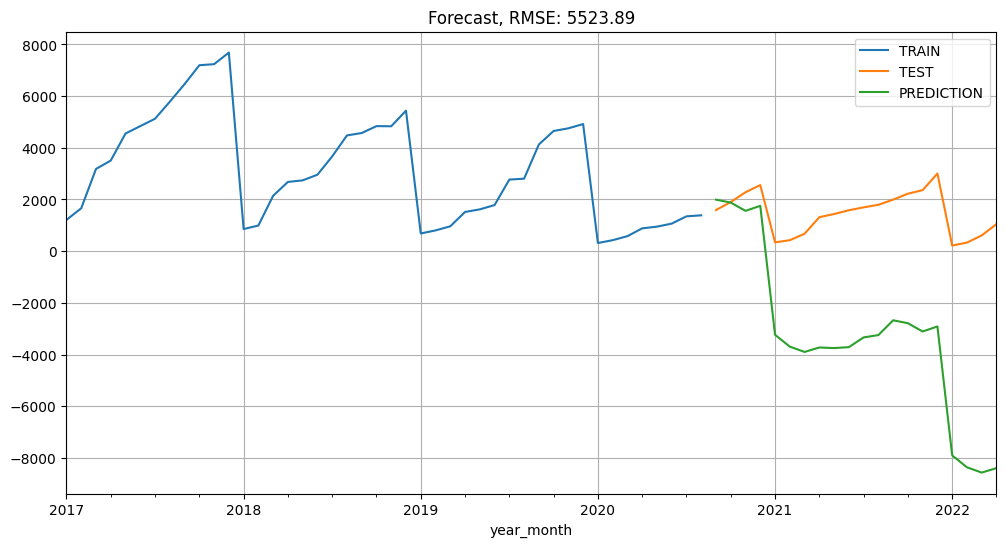

In [13]:
plot_co2(train_data['Demand'], validation_data['Demand'], y_pred, "Forecast")

In [14]:
best_alpha, best_beta, best_gamma, best_mae = tes_optimizer(train_data['Demand'],validation_data['Demand'], abg)

/Users/cristiantabaresbran/opt/anaconda3/lib/python3.10/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
/Users/cristiantabaresbran/opt/anaconda3/lib/python3.10/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
/Users/cristiantabaresbran/opt/anaconda3/lib/python3.10/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
/Users/cristiantabaresbran/opt/anaconda3/lib/python3.10/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
/Users/cristiantabaresbran/opt/anaconda3/lib/python3.10/site-package

[0.1, 0.1, 0.1, 1644.14]
best_alpha: 0.1 best_beta: 0.1 best_gamma: 0.1 best_mae: 1644.1385
[0.1, 0.1, 0.3, 1595.85]
best_alpha: 0.1 best_beta: 0.1 best_gamma: 0.3 best_mae: 1595.8549
[0.1, 0.1, 0.5, 1503.84]
best_alpha: 0.1 best_beta: 0.1 best_gamma: 0.5 best_mae: 1503.8444
[0.1, 0.1, 0.7, 1434.04]
best_alpha: 0.1 best_beta: 0.1 best_gamma: 0.7 best_mae: 1434.0416
[0.1, 0.1, 0.9, 1430.27]
best_alpha: 0.1 best_beta: 0.1 best_gamma: 0.9 best_mae: 1430.2699
[0.1, 0.3, 0.1, 1540.98]
best_alpha: 0.1 best_beta: 0.1 best_gamma: 0.9 best_mae: 1430.2699
[0.1, 0.3, 0.3, 1570.84]
best_alpha: 0.1 best_beta: 0.1 best_gamma: 0.9 best_mae: 1430.2699
[0.1, 0.3, 0.5, 1562.41]
best_alpha: 0.1 best_beta: 0.1 best_gamma: 0.9 best_mae: 1430.2699
[0.1, 0.3, 0.7, 1600.97]
best_alpha: 0.1 best_beta: 0.1 best_gamma: 0.9 best_mae: 1430.2699
[0.1, 0.3, 0.9, 1707.12]
best_alpha: 0.1 best_beta: 0.1 best_gamma: 0.9 best_mae: 1430.2699
[0.1, 0.5, 0.1, 2237.83]
best_alpha: 0.1 best_beta: 0.1 best_gamma: 0.9 best_mae

/Users/cristiantabaresbran/opt/anaconda3/lib/python3.10/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
/Users/cristiantabaresbran/opt/anaconda3/lib/python3.10/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
/Users/cristiantabaresbran/opt/anaconda3/lib/python3.10/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
/Users/cristiantabaresbran/opt/anaconda3/lib/python3.10/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
/Users/cristiantabaresbran/opt/anaconda3/lib/python3.10/site-package

[0.1, 0.7, 0.1, 3223.04]
best_alpha: 0.1 best_beta: 0.1 best_gamma: 0.9 best_mae: 1430.2699
[0.1, 0.7, 0.3, 2943.17]
best_alpha: 0.1 best_beta: 0.1 best_gamma: 0.9 best_mae: 1430.2699
[0.1, 0.7, 0.5, 2558.63]
best_alpha: 0.1 best_beta: 0.1 best_gamma: 0.9 best_mae: 1430.2699
[0.1, 0.7, 0.7, 2357.44]
best_alpha: 0.1 best_beta: 0.1 best_gamma: 0.9 best_mae: 1430.2699
[0.1, 0.7, 0.9, 2224.36]
best_alpha: 0.1 best_beta: 0.1 best_gamma: 0.9 best_mae: 1430.2699
[0.1, 0.9, 0.1, 3396.85]
best_alpha: 0.1 best_beta: 0.1 best_gamma: 0.9 best_mae: 1430.2699
[0.1, 0.9, 0.3, 2977.91]
best_alpha: 0.1 best_beta: 0.1 best_gamma: 0.9 best_mae: 1430.2699
[0.1, 0.9, 0.5, 2636.21]
best_alpha: 0.1 best_beta: 0.1 best_gamma: 0.9 best_mae: 1430.2699
[0.1, 0.9, 0.7, 2466.21]
best_alpha: 0.1 best_beta: 0.1 best_gamma: 0.9 best_mae: 1430.2699
[0.1, 0.9, 0.9, 2300.7]
best_alpha: 0.1 best_beta: 0.1 best_gamma: 0.9 best_mae: 1430.2699
[0.3, 0.1, 0.1, 2083.79]
best_alpha: 0.1 best_beta: 0.1 best_gamma: 0.9 best_mae:

/Users/cristiantabaresbran/opt/anaconda3/lib/python3.10/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
/Users/cristiantabaresbran/opt/anaconda3/lib/python3.10/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
/Users/cristiantabaresbran/opt/anaconda3/lib/python3.10/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
/Users/cristiantabaresbran/opt/anaconda3/lib/python3.10/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
/Users/cristiantabaresbran/opt/anaconda3/lib/python3.10/site-package

[0.3, 0.3, 0.3, 3646.89]
best_alpha: 0.1 best_beta: 0.1 best_gamma: 0.9 best_mae: 1430.2699
[0.3, 0.3, 0.5, 3378.54]
best_alpha: 0.1 best_beta: 0.1 best_gamma: 0.9 best_mae: 1430.2699
[0.3, 0.3, 0.7, 2983.67]
best_alpha: 0.1 best_beta: 0.1 best_gamma: 0.9 best_mae: 1430.2699
[0.3, 0.3, 0.9, 2581.59]
best_alpha: 0.1 best_beta: 0.1 best_gamma: 0.9 best_mae: 1430.2699
[0.3, 0.5, 0.1, 5343.09]
best_alpha: 0.1 best_beta: 0.1 best_gamma: 0.9 best_mae: 1430.2699
[0.3, 0.5, 0.3, 5327.28]
best_alpha: 0.1 best_beta: 0.1 best_gamma: 0.9 best_mae: 1430.2699
[0.3, 0.5, 0.5, 4980.61]
best_alpha: 0.1 best_beta: 0.1 best_gamma: 0.9 best_mae: 1430.2699
[0.3, 0.5, 0.7, 4461.73]
best_alpha: 0.1 best_beta: 0.1 best_gamma: 0.9 best_mae: 1430.2699
[0.3, 0.5, 0.9, 3825.83]
best_alpha: 0.1 best_beta: 0.1 best_gamma: 0.9 best_mae: 1430.2699
[0.3, 0.7, 0.1, 6281.22]
best_alpha: 0.1 best_beta: 0.1 best_gamma: 0.9 best_mae: 1430.2699
[0.3, 0.7, 0.3, 6132.57]
best_alpha: 0.1 best_beta: 0.1 best_gamma: 0.9 best_mae

/Users/cristiantabaresbran/opt/anaconda3/lib/python3.10/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
/Users/cristiantabaresbran/opt/anaconda3/lib/python3.10/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
/Users/cristiantabaresbran/opt/anaconda3/lib/python3.10/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
/Users/cristiantabaresbran/opt/anaconda3/lib/python3.10/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
/Users/cristiantabaresbran/opt/anaconda3/lib/python3.10/site-package

[0.3, 0.9, 0.9, 5420.34]
best_alpha: 0.1 best_beta: 0.1 best_gamma: 0.9 best_mae: 1430.2699
[0.5, 0.1, 0.1, 2580.15]
best_alpha: 0.1 best_beta: 0.1 best_gamma: 0.9 best_mae: 1430.2699
[0.5, 0.1, 0.3, 2652.0]
best_alpha: 0.1 best_beta: 0.1 best_gamma: 0.9 best_mae: 1430.2699
[0.5, 0.1, 0.5, 2626.44]
best_alpha: 0.1 best_beta: 0.1 best_gamma: 0.9 best_mae: 1430.2699
[0.5, 0.1, 0.7, 2509.74]
best_alpha: 0.1 best_beta: 0.1 best_gamma: 0.9 best_mae: 1430.2699
[0.5, 0.1, 0.9, 2310.71]
best_alpha: 0.1 best_beta: 0.1 best_gamma: 0.9 best_mae: 1430.2699
[0.5, 0.3, 0.1, 4422.0]
best_alpha: 0.1 best_beta: 0.1 best_gamma: 0.9 best_mae: 1430.2699
[0.5, 0.3, 0.3, 4532.34]
best_alpha: 0.1 best_beta: 0.1 best_gamma: 0.9 best_mae: 1430.2699
[0.5, 0.3, 0.5, 4530.6]
best_alpha: 0.1 best_beta: 0.1 best_gamma: 0.9 best_mae: 1430.2699
[0.5, 0.3, 0.7, 4349.68]
best_alpha: 0.1 best_beta: 0.1 best_gamma: 0.9 best_mae: 1430.2699
[0.5, 0.3, 0.9, 3903.45]
best_alpha: 0.1 best_beta: 0.1 best_gamma: 0.9 best_mae: 1

/Users/cristiantabaresbran/opt/anaconda3/lib/python3.10/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
/Users/cristiantabaresbran/opt/anaconda3/lib/python3.10/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
/Users/cristiantabaresbran/opt/anaconda3/lib/python3.10/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
/Users/cristiantabaresbran/opt/anaconda3/lib/python3.10/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
/Users/cristiantabaresbran/opt/anaconda3/lib/python3.10/site-package

[0.5, 0.7, 0.9, 4506.94]
best_alpha: 0.1 best_beta: 0.1 best_gamma: 0.9 best_mae: 1430.2699
[0.5, 0.9, 0.1, 5296.63]
best_alpha: 0.1 best_beta: 0.1 best_gamma: 0.9 best_mae: 1430.2699
[0.5, 0.9, 0.3, 5508.58]
best_alpha: 0.1 best_beta: 0.1 best_gamma: 0.9 best_mae: 1430.2699
[0.5, 0.9, 0.5, 5540.18]
best_alpha: 0.1 best_beta: 0.1 best_gamma: 0.9 best_mae: 1430.2699
[0.5, 0.9, 0.7, 4944.66]
best_alpha: 0.1 best_beta: 0.1 best_gamma: 0.9 best_mae: 1430.2699
[0.5, 0.9, 0.9, 4027.48]
best_alpha: 0.1 best_beta: 0.1 best_gamma: 0.9 best_mae: 1430.2699
[0.7, 0.1, 0.1, 2819.3]
best_alpha: 0.1 best_beta: 0.1 best_gamma: 0.9 best_mae: 1430.2699
[0.7, 0.1, 0.3, 2868.85]
best_alpha: 0.1 best_beta: 0.1 best_gamma: 0.9 best_mae: 1430.2699
[0.7, 0.1, 0.5, 2848.28]
best_alpha: 0.1 best_beta: 0.1 best_gamma: 0.9 best_mae: 1430.2699
[0.7, 0.1, 0.7, 2770.41]
best_alpha: 0.1 best_beta: 0.1 best_gamma: 0.9 best_mae: 1430.2699
[0.7, 0.1, 0.9, 2611.37]
best_alpha: 0.1 best_beta: 0.1 best_gamma: 0.9 best_mae:

/Users/cristiantabaresbran/opt/anaconda3/lib/python3.10/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
/Users/cristiantabaresbran/opt/anaconda3/lib/python3.10/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
/Users/cristiantabaresbran/opt/anaconda3/lib/python3.10/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
/Users/cristiantabaresbran/opt/anaconda3/lib/python3.10/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
/Users/cristiantabaresbran/opt/anaconda3/lib/python3.10/site-package

[0.7, 0.5, 0.9, 3936.57]
best_alpha: 0.1 best_beta: 0.1 best_gamma: 0.9 best_mae: 1430.2699
[0.7, 0.7, 0.1, 5420.18]
best_alpha: 0.1 best_beta: 0.1 best_gamma: 0.9 best_mae: 1430.2699
[0.7, 0.7, 0.3, 5174.49]
best_alpha: 0.1 best_beta: 0.1 best_gamma: 0.9 best_mae: 1430.2699
[0.7, 0.7, 0.5, 4836.0]
best_alpha: 0.1 best_beta: 0.1 best_gamma: 0.9 best_mae: 1430.2699
[0.7, 0.7, 0.7, 4231.72]
best_alpha: 0.1 best_beta: 0.1 best_gamma: 0.9 best_mae: 1430.2699
[0.7, 0.7, 0.9, 3510.7]
best_alpha: 0.1 best_beta: 0.1 best_gamma: 0.9 best_mae: 1430.2699
[0.7, 0.9, 0.1, 5742.93]
best_alpha: 0.1 best_beta: 0.1 best_gamma: 0.9 best_mae: 1430.2699
[0.7, 0.9, 0.3, 5375.86]
best_alpha: 0.1 best_beta: 0.1 best_gamma: 0.9 best_mae: 1430.2699
[0.7, 0.9, 0.5, 4754.94]
best_alpha: 0.1 best_beta: 0.1 best_gamma: 0.9 best_mae: 1430.2699
[0.7, 0.9, 0.7, 3643.8]
best_alpha: 0.1 best_beta: 0.1 best_gamma: 0.9 best_mae: 1430.2699
[0.7, 0.9, 0.9, 2841.52]
best_alpha: 0.1 best_beta: 0.1 best_gamma: 0.9 best_mae: 1

/Users/cristiantabaresbran/opt/anaconda3/lib/python3.10/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
/Users/cristiantabaresbran/opt/anaconda3/lib/python3.10/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
/Users/cristiantabaresbran/opt/anaconda3/lib/python3.10/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
/Users/cristiantabaresbran/opt/anaconda3/lib/python3.10/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
/Users/cristiantabaresbran/opt/anaconda3/lib/python3.10/site-package

In [15]:
final_tes_model = ExponentialSmoothing(train_data['Demand'], trend="add", seasonal="add", seasonal_periods=12).fit(smoothing_level=best_alpha, smoothing_trend=best_beta, smoothing_seasonal=best_gamma)

/Users/cristiantabaresbran/opt/anaconda3/lib/python3.10/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)


In [16]:
y_pred = final_tes_model.forecast(20)

RMSE: 1176.9622377004894


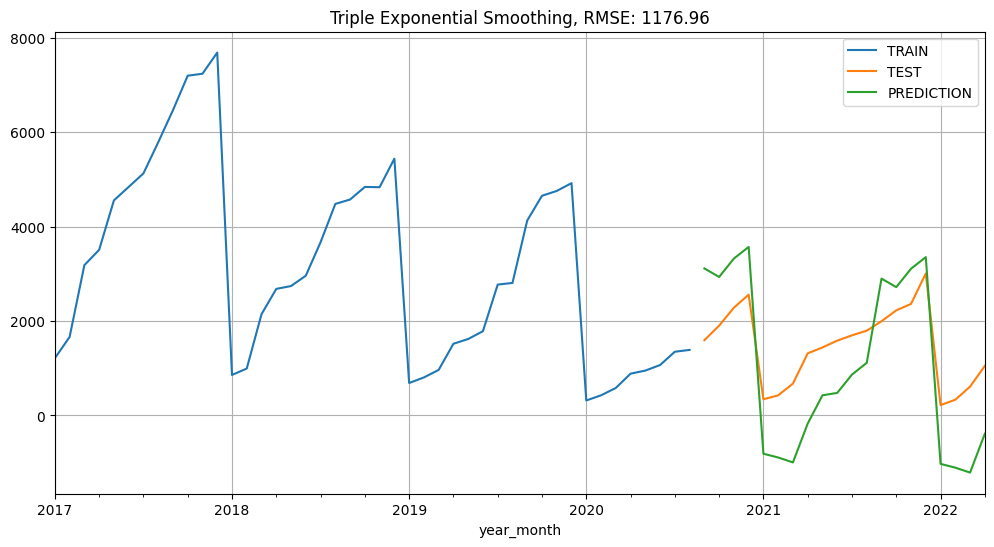

In [17]:
plot_co2(train_data['Demand'], validation_data['Demand'], y_pred, "Triple Exponential Smoothing")

In [18]:
final_tes_model = ExponentialSmoothing(data['Demand'], trend="add", seasonal="add", seasonal_periods=12).fit(smoothing_level=best_alpha, smoothing_trend=best_beta, smoothing_seasonal=best_gamma)

/Users/cristiantabaresbran/opt/anaconda3/lib/python3.10/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)


In [19]:
forecast = final_tes_model.predict(start='2022-05-01', end='2022-07-01')
forecast

2022-05-01    1485.907205
2022-06-01    2054.879707
2022-07-01    2205.588802
Freq: MS, dtype: float64

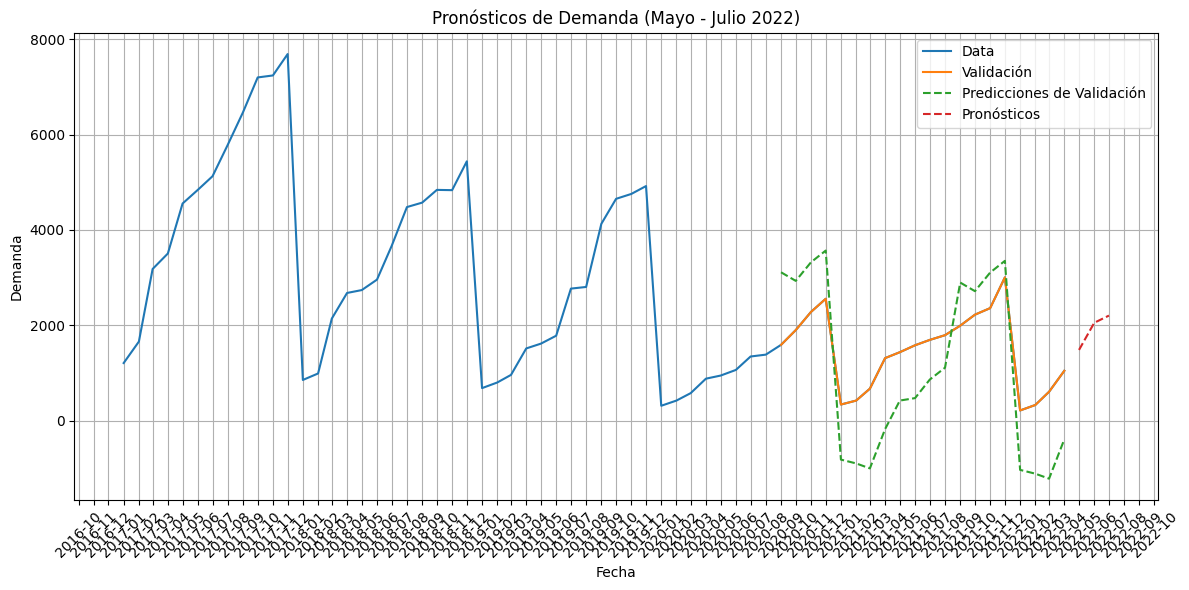

In [39]:
plt.figure(figsize=(12, 6))
plt.plot(combined_data.year_month, combined_data['Demand'], label='Data')
plt.plot(validation_data.index, validation_data['Demand'], label='Validación')
plt.plot(validation_data.index, y_pred, label='Predicciones de Validación', linestyle='--')
plt.plot(forecast.index, forecast, label='Pronósticos', linestyle='--')
plt.title('Pronósticos de Demanda (Mayo - Julio 2022)')
plt.xlabel('Fecha')
plt.ylabel('Demanda')
plt.legend()
plt.gca().xaxis.set_major_locator(mdates.MonthLocator())
plt.gca().xaxis.set_major_formatter(mdates.DateFormatter('%Y-%m'))

plt.legend()
plt.grid(True)
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()

Punto 2

In [22]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler, OneHotEncoder
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
from sklearn.decomposition import TruncatedSVD
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import classification_report, confusion_matrix, accuracy_score
import joblib


# 1. Carga y Exploración de Datos
data = pd.read_csv('bds/dataset_alpha_betha.csv')



In [23]:
data.dtypes

autoID               object
SeniorCity            int64
Partner              object
Dependents           object
Service1             object
Service2             object
Security             object
OnlineBackup         object
DeviceProtection     object
TechSupport          object
Contract             object
PaperlessBilling     object
PaymentMethod        object
Charges             float64
Demand               object
Class                object
dtype: object

In [24]:
data.isna().sum()

autoID              0
SeniorCity          0
Partner             0
Dependents          0
Service1            0
Service2            0
Security            0
OnlineBackup        0
DeviceProtection    0
TechSupport         0
Contract            0
PaperlessBilling    0
PaymentMethod       0
Charges             0
Demand              0
Class               0
dtype: int64

In [25]:
data['Demand'] = pd.to_numeric(data['Demand'], errors='coerce')

In [26]:
data.isna().sum()

autoID               0
SeniorCity           0
Partner              0
Dependents           0
Service1             0
Service2             0
Security             0
OnlineBackup         0
DeviceProtection     0
TechSupport          0
Contract             0
PaperlessBilling     0
PaymentMethod        0
Charges              0
Demand              11
Class                0
dtype: int64

In [27]:
data[data['Demand'].isna() ==True]

,autoID,SeniorCity,Partner,Dependents,Service1,Service2,Security,OnlineBackup,DeviceProtection,TechSupport,Contract,PaperlessBilling,PaymentMethod,Charges,Demand,Class
488,4472-LVYGI,0,Yes,Yes,No,No phone service,Yes,No,Yes,Yes,Two year,Yes,Bank transfer (automatic),52.55,NaN,Alpha
753,3115-CZMZD,0,No,Yes,Yes,No,No internet service,No internet service,No internet service,No internet service,Two year,No,Mailed check,20.25,NaN,Alpha
936,5709-LVOEQ,0,Yes,Yes,Yes,No,Yes,Yes,Yes,No,Two year,No,Mailed check,80.85,NaN,Alpha
1082,4367-NUYAO,0,Yes,Yes,Yes,Yes,No internet service,No internet service,No internet service,No internet service,Two year,No,Mailed check,25.75,NaN,Alpha
1340,1371-DWPAZ,0,Yes,Yes,No,No phone service,Yes,Yes,Yes,Yes,Two year,No,Credit card (automatic),56.05,NaN,Alpha
3331,7644-OMVMY,0,Yes,Yes,Yes,No,No internet service,No internet service,No internet service,No internet service,Two year,No,Mailed check,19.85,NaN,Alpha
3826,3213-VVOLG,0,Yes,Yes,Yes,Yes,No internet service,No internet service,No internet service,No internet service,Two year,No,Mailed check,25.35,NaN,Alpha
4380,2520-SGTTA,0,Yes,Yes,Yes,No,No internet service,No internet service,No internet service,No internet service,Two year,No,Mailed check,20.00,NaN,Alpha
5218,2923-ARZLG,0,Yes,Yes,Yes,No,No internet service,No internet service,No internet service,No internet service,One year,Yes,Mailed check,19.70,NaN,Alpha
6670,4075-WKNIU,0,Yes,Yes,Yes,Yes,No,Yes,Yes,Yes,Two year,No,Mailed check,73.35,NaN,Alpha


In [28]:
data.dropna(inplace=True)

In [29]:
# Separar características y etiquetas
X = data.drop('Class', axis=1)  # Asegúrate de que 'class' es el nombre de la columna de etiquetas
y = data['Class']

In [30]:
categorical_cols = X.select_dtypes(include=['object']).columns
numerical_cols = X.select_dtypes(exclude=['object']).columns

# Crear un preprocesador para las columnas categóricas y numéricas
preprocessor = ColumnTransformer(
    transformers=[
        ('num', StandardScaler(), numerical_cols),
        ('cat', OneHotEncoder(handle_unknown='ignore', sparse_output=False), categorical_cols)
    ])

# Crear un pipeline con preprocesamiento, TruncatedSVD y el modelo
pipeline = Pipeline(steps=[
    ('preprocessor', preprocessor),
    ('svd', TruncatedSVD(n_components=10)),  # Ajusta el número de componentes según sea necesario
    ('classifier', RandomForestClassifier(n_estimators=100, random_state=42))
])

In [31]:
# 3. División de los Datos en Conjuntos de Entrenamiento y Testeo (70-30)
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=42)

# 4. Entrenamiento del Modelo de Clasificación
pipeline.fit(X_train, y_train)

Pipeline(steps=[('preprocessor',
                 ColumnTransformer(transformers=[('num', StandardScaler(),
                                                  Index(['SeniorCity', 'Charges', 'Demand'], dtype='object')),
                                                 ('cat',
                                                  OneHotEncoder(handle_unknown='ignore',
                                                                sparse_output=False),
                                                  Index(['autoID', 'Partner', 'Dependents', 'Service1', 'Service2', 'Security',
       'OnlineBackup', 'DeviceProtection', 'TechSupport', 'Contract',
       'PaperlessBilling', 'PaymentMethod'],
      dtype='object'))])),
                ('svd', TruncatedSVD(n_components=10)),
                ('classifier', RandomForestClassifier(random_state=42))])

In [32]:
# 5. Evaluación del Modelo
y_pred = pipeline.predict(X_test)

accuracy = accuracy_score(y_test, y_pred)
conf_matrix = confusion_matrix(y_test, y_pred)
class_report = classification_report(y_test, y_pred)

print(f'Accuracy: {accuracy}')
print('Confusion Matrix:')
print(conf_matrix)
print('Classification Report:')
print(class_report)



Accuracy: 0.7654028436018957
Confusion Matrix:
[[1374  175]
 [ 320  241]]
Classification Report:
              precision    recall  f1-score   support

       Alpha       0.81      0.89      0.85      1549
       Betha       0.58      0.43      0.49       561

    accuracy                           0.77      2110
   macro avg       0.70      0.66      0.67      2110
weighted avg       0.75      0.77      0.75      2110



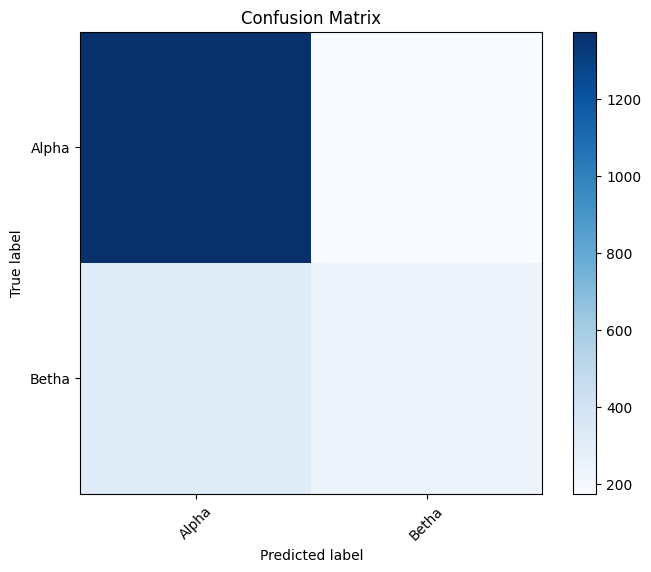

In [33]:
# Graficar Matriz de Confusión
plt.figure(figsize=(8, 6))
plt.imshow(conf_matrix, interpolation='nearest', cmap=plt.cm.Blues)
plt.title('Confusion Matrix')
plt.colorbar()
plt.xticks(np.arange(len(pipeline.named_steps['classifier'].classes_)), pipeline.named_steps['classifier'].classes_, rotation=45)
plt.yticks(np.arange(len(pipeline.named_steps['classifier'].classes_)), pipeline.named_steps['classifier'].classes_)
plt.ylabel('True label')
plt.xlabel('Predicted label')
plt.show()


In [34]:
# 6. Exportación del Modelo y Métricas
# Guardar el pipeline entrenado (incluye preprocesamiento, TruncatedSVD y modelo)
joblib.dump(pipeline, 'api_project/model/classification_pipeline.pkl')

# Guardar las métricas en un archivo txt
with open('results/model_metrics.txt', 'w') as f:
    f.write(f'Accuracy: {accuracy}\n')
    f.write('Confusion Matrix:\n')
    f.write(np.array2string(conf_matrix))
    f.write('\nClassification Report:\n')
    f.write(class_report)

In [35]:
# Información adicional
with open('results/model_info.txt', 'w') as f:
    f.write('Modelo: RandomForestClassifier\n')
    f.write(f'Número de datos de entrenamiento: {len(X_train)}\n')
    f.write(f'Número de datos de testeo: {len(X_test)}\n')
    f.write(f'Componentes TruncatedSVD: 10\n')  # Ajustar si cambias el número de componentes
    f.write(f'Número de estimadores: {pipeline.named_steps["classifier"].n_estimators}\n')

In [36]:
import pandas as pd
from sklearn.pipeline import Pipeline
import joblib

# Cargar el modelo entrenado
model = joblib.load('api_project/model/classification_pipeline.pkl')

# Cargar el dataset
df_to_predict = pd.read_csv('bds/to_predict.csv')




In [37]:
forecast_df = forecast.reset_index()
forecast_df.columns = ['year_month', 'Demand']

In [38]:
df_to_predict

,autoID,SeniorCity,Partner,Dependents,Service1,Service2,Security,OnlineBackup,DeviceProtection,TechSupport,Contract,PaperlessBilling,PaymentMethod,Charges,Demand,Class
0,9695-TERGH,0,No,No,Yes,No,Yes,No,No,No,Month-to-month,Yes,Electronic check,96.05,NaN,NaN
1,5247-VRIOW,0,No,No,Yes,No,Yes,No,No,Yes,Month-to-month,No,Mailed check,53.45,NaN,NaN
2,5731-DDJUB,0,No,No,Yes,No,No internet service,No internet service,No internet service,No internet service,Two year,No,Bank transfer (automatic),19.70,NaN,NaN


In [39]:
df_to_predict['Demand'] = forecast_df['Demand']

y = df_to_predict['Class']
df_to_predict.drop(['Class'],axis=1, inplace=True)

# Crear la carpeta api_project si no existe
output_dir = 'api_project'
if not os.path.exists(output_dir):
    os.makedirs(output_dir)
# Exportar el DataFrame a JSON en la carpeta api_project
json_file_path = os.path.join(output_dir, 'input_data.json')

df_to_predict.to_json(json_file_path, orient='records', lines=False, indent=4)

print(f"Archivo JSON guardado en: {json_file_path}")

Archivo JSON guardado en: api_project/input_data.json


In [40]:
# Realizar la predicción de la demanda
predictions = pipeline.predict(df_to_predict)

# Añadir las predicciones al DataFrame
df_to_predict['Class'] = predictions

# Guardar el DataFrame actualizado
df_to_predict.to_csv('results/to_predict_with_demand_and_class.csv', index=False)